### Imports and set path to local mavenn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

import warnings
warnings.filterwarnings('ignore')

import sys
path_to_mavenn_local = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local'
sys.path.insert(0,path_to_mavenn_local)

import mavenn
from mavenn.src.utils import get_example_dataset
from mavenn.src.utils import ge_plots_for_mavenn_demo
from mavenn.src.utils import onehot_encode_array, _generate_nbr_features_from_sequences, _generate_all_pair_features_from_sequences
from mavenn.src.utils import _center_matrix

import tensorflow as tf
import tensorflow.keras.backend as K

# Path being used:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn']

### Load data, and estimate instrinsic information

In [2]:
# Load these data so that we may use test data for predictions.
MPSA_data = pd.read_csv('20.08.16_mpsa_data/brca2_lib1_rep1.csv')
MPSA_data.head()

X = MPSA_data['ss'].values
y = MPSA_data['log_psi'].values
dy = MPSA_data['dlog_psi'].values

ix = (y > 0) & (dy > 0)
mavenn.estimate_instrinsic_information(y[ix],dy[ix],True)

H[y]   = +1.0574 +- 0.0286 bits
H[y|x] = -1.7274 +- 0.0535 bits
I[y;x] = +2.7849 +- 0.0606 bits


(2.7848558850461114, 0.06064920959172996)

In [3]:
# split data into test, we only need test data here, the loaded
# model will already contain the training data it was trained on
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 0)

## Load model from file

In [4]:
# GER_additive = mavenn.load('model_files/gaussian_mpsa_model_additive')
# GER_pairwise = mavenn.load('model_files/gaussian_mpsa_model')

GER_additive = mavenn.load('model_files/skewT_mpsa_model_additive')
GER_pairwise = mavenn.load('model_files/skewT_mpsa_model_pairwise')


In [5]:
GER_additive.gpmap_type,GER_pairwise.gpmap_type

('additive', 'pairwise')

### Make predictions and compute latent phenotype values

In [6]:
# predictions
yhat_additive = GER_additive.x_to_yhat(x_test)

# evaluate phi for sequences 
phi_additive = GER_additive.x_to_phi(x_test)

# equalate g(phi) for continuous phi
phi_range_additive = np.linspace(min(phi_additive),max(phi_additive),1000)
y_hat_GE_additive = GER_additive.phi_to_yhat(phi_range_additive)

# noise model that is used to get eta parameters
qs_additive = GER_additive.yhat_to_yq(y_hat_GE_additive,q=[0.16,0.84])

In [7]:
# predictions
yhat_pairwise = GER_pairwise.x_to_yhat(x_test)

# evaluate phi for sequences 
phi_pairwise = GER_pairwise.x_to_phi(x_test)

# equalate g(phi) for continuous phi
phi_range_pairwise = np.linspace(min(phi_pairwise),max(phi_pairwise),1000)
y_hat_GE_pairwise = GER_pairwise.phi_to_yhat(phi_range_pairwise)

# noise model that is used to get eta parameters
qs_pairwise = GER_pairwise.yhat_to_yq(y_hat_GE_pairwise,q=[0.16,0.84])

In [8]:
SH_train = pd.read_excel('Sailer_Harms_Spline_fit_MPSA_data.xlsx',sheet_name='train')
SH_test = pd.read_excel('Sailer_Harms_Spline_fit_MPSA_data.xlsx',sheet_name='test')
SH_line = pd.read_excel('Sailer_Harms_Spline_fit_MPSA_data.xlsx',sheet_name='line')

## Show plots

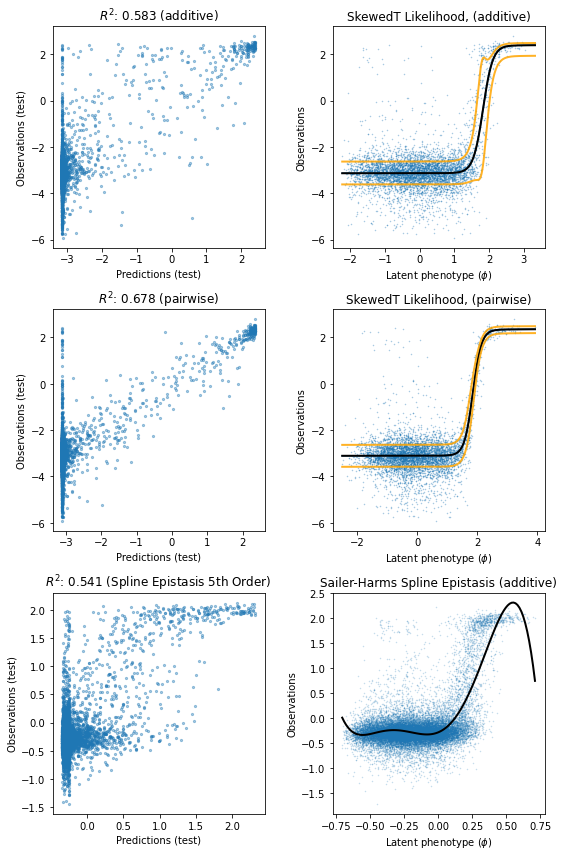

In [9]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

Rsq = np.corrcoef(yhat_additive.ravel(),y_test)[0][1]**2
ax[0,0].scatter(yhat_additive,y_test,s=5,alpha=0.4)
ax[0,0].set_xlabel('Predictions (test)')
ax[0,0].set_ylabel('Observations (test)')
ax[0,0].set_title('$R^2$: '+str(Rsq)[0:5]+' (additive)')

ax[0,1].plot(phi_range_additive,GER_additive.phi_to_yhat(phi_range_additive))
ax[0,1].scatter(phi_additive,y_test,s=0.25, alpha=0.4, label='Observations')
ax[0,1].plot(phi_range_additive,GER_additive.phi_to_yhat(phi_range_additive),lw=2,label='$\hat{y}$',alpha=1.0,color='black')

for q_index in range(len(qs_additive)):
    ax[0,1].plot(phi_range_additive,qs_additive[q_index].ravel(),color='orange',lw=2,alpha=0.85,label='$\hat{y} \pm \sigma(\hat{y})$')

ax[0,1].set_ylabel('Observations')
ax[0,1].set_xlabel('Latent phenotype ($\phi$)')
ax[0,1].set_title(GER_additive.ge_noise_model_type+' Likelihood, (additive)')

Rsq = np.corrcoef(yhat_pairwise.ravel(),y_test)[0][1]**2
ax[1,0].scatter(yhat_pairwise,y_test,s=5,alpha=0.4)
ax[1,0].set_xlabel('Predictions (test)')
ax[1,0].set_ylabel('Observations (test)')
ax[1,0].set_title('$R^2$: '+str(Rsq)[0:5]+' (pairwise)')

ax[1,1].plot(phi_range_pairwise,GER_pairwise.phi_to_yhat(phi_range_pairwise))
ax[1,1].scatter(phi_pairwise,y_test,s=0.25, alpha=0.4, label='Observations')
ax[1,1].plot(phi_range_pairwise,GER_pairwise.phi_to_yhat(phi_range_pairwise),lw=2,label='$\hat{y}$',alpha=1.0,color='black')

for q_index in range(len(qs_pairwise)):
    ax[1,1].plot(phi_range_pairwise,qs_pairwise[q_index].ravel(),color='orange',lw=2,alpha=0.85,label='$\hat{y} \pm \sigma(\hat{y})$')

ax[1,1].set_ylabel('Observations')
ax[1,1].set_xlabel('Latent phenotype ($\phi$)')
ax[1,1].set_title(GER_pairwise.ge_noise_model_type+' Likelihood, (pairwise)')

ax[2,1].scatter(SH_train['y_add'].values,SH_train['y_obs'].values,s=0.25,alpha=0.25)
ax[2,1].plot(SH_line['y_add_line'].values,SH_line['y_obs_line'].values,color='black',lw=2)
ax[2,1].set_xlabel('Latent phenotype ($\phi$)')
ax[2,1].set_ylabel('Observations')
ax[2,1].set_title('Sailer-Harms Spline Epistasis (additive)')

Rsq = np.corrcoef(SH_test['yhat_test'].values,SH_test['y_test'].values)[0][1]**2
ax[2,0].scatter(SH_test['yhat_test'].values,SH_test['y_test'].values,s=5,alpha=0.4)
ax[2,0].set_xlabel('Predictions (test)')
ax[2,0].set_ylabel('Observations (test)')
ax[2,0].set_title('$R^2$: '+str(Rsq)[0:5]+' (Spline Epistasis 5th Order)')

plt.tight_layout()
plt.show()